In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/WELFake_Dataset.csv')

In [ ]:
df=df.dropna()
df=df.reset_index()
df=df[["text",'label']]


In [ ]:
import re
import string
def clean_text(article):
    #print(article)
    text = article.lower()
    text = text.replace('\n', " ")
    tokens = text.split(" ")
    regex = "[a-zA-Z]"
    refined_tokens = []
    for item in tokens:
        if re.match(regex, item):
            refined_tokens.append(item)
    cleaned_text = ' '.join(token for token in refined_tokens)
    return cleaned_text.translate(str.maketrans('', '', string.punctuation))

In [ ]:

df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
df=df[["cleaned_text","label"]]
df.shape

(71537, 2)

In [ ]:
df = df.loc[0:10000, :]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of label ')

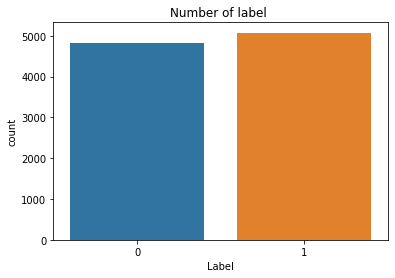

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Number of label ')

In [ ]:
df.to_csv('/content/drive/MyDrive/cleaned_data1.csv')

In [ ]:
dff=pd.read_csv('/content/drive/MyDrive/cleaned_data1.csv',lineterminator="\n")

In [ ]:
df=dff[["cleaned_text","label"]]

In [ ]:
import torch
!pip install transformers
import transformers as ppb

import pandas as pd
import numpy as np

gpu_available = False
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    gpu_available = True

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


print("finish loading library")

torch.manual_seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
finish loading library


In [ ]:
df=dff.dropna()

In [ ]:
df = df.reset_index()

In [ ]:
df=df[["cleaned_text","label"]]

In [ ]:
df.head(10)

,cleaned_text,label
0,no comment is expected from barack obama membe...,1
1,now most of the demonstrators gathered last ni...,1
2,a dozen politically active pastors came here f...,0
3,the rs28 sarmat missile dubbed satan will repl...,1
4,all we can say on this one is it s about time ...,1
5,dr ben carson tells the story of what happened...,1
6,the owner of the ringling bar located south of...,1
7,file in this sept file photo the marker that w...,1
8,the most punchable altright nazi on the intern...,1
9,brussels british prime minister theresa may s ...,0


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [ ]:
train=train[["cleaned_text","label"]]

In [ ]:
test.reset_index()
test=test[["cleaned_text","label"]]

In [ ]:
train.to_csv('/content/drive/MyDrive/train.csv')
test.to_csv('/content/drive/MyDrive/test.csv')


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import re
from sklearn import metrics

#Load training and test data
#Change the path if needed
training_data = pd.read_csv("/content/drive/MyDrive/train.csv", index_col = 0,lineterminator="\n")
test_data = pd.read_csv("/content/drive/MyDrive/test.csv", index_col = 0,lineterminator="\n")

training_label = training_data["label"].values
training_content = training_data["cleaned_text"].values.astype("str")


test_label = test_data["label"].values
test_content = test_data["cleaned_text"].values.astype("str")



print("finish loading data")

finish loading data


In [ ]:
#Tokenization
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup, BertForMultipleChoice
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case = True)
training_input_ids = []
training_attention_masks = []

# For every sentence...
for sent in training_data['cleaned_text']:
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 128,       
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                        # return_overflowing_tokens = False
                   )
    
    training_input_ids.append(encoded_dict['input_ids'])
    
    training_attention_masks.append(encoded_dict['attention_mask'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

training_input_ids = torch.cat(training_input_ids, dim=0)
training_attention_masks = torch.cat(training_attention_masks, dim=0)
training_labels = torch.tensor(training_label, dtype = torch.long)   



test_input_ids = []
test_attention_masks = []


for sent in test_data['cleaned_text']:
    encoded = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 128,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    test_input_ids.append(encoded['input_ids'])
    test_attention_masks.append(encoded['attention_mask'])

validation_inputs = torch.cat(test_input_ids, dim=0)
validation_masks = torch.cat(test_attention_masks, dim=0)
validation_labels = torch.tensor(test_label, dtype = torch.long)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_label, dtype = torch.long)


              
print("finish tokenization")

finish tokenization


In [ ]:

#Generate Dataset

from torch.utils.data import TensorDataset

train_dataset = TensorDataset(training_input_ids, training_attention_masks, training_labels)
val_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 8 #16


train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = len(test_data) 
        )



In [ ]:


from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup, BertForMultipleChoice



model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = 2, output_attentions = False, output_hidden_states = False)

                    


model.cuda()


optimizer = AdamW(model.parameters(), lr = 3e-5, eps =1e-8)




Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [ ]:
from transformers import get_linear_schedule_with_warmup


epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)


import numpy as np

from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import confusion_matrix


def flat_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    print(confusion_matrix(labels_flat, pred_flat))
    score = precision_recall_fscore_support(labels_flat, pred_flat, average = None)
    return np.sum(pred_flat == labels_flat) / len(labels_flat), score[0][1], score[1][1], score[2][1]



import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''

    elapsed_rounded = int(round((elapsed)))
    

    return str(datetime.timedelta(seconds=elapsed_rounded))


import random
import numpy as np


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []


total_t0 = time.time()


for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):


        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
  
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()  
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    torch.save(model.state_dict(),'bert' + str(epoch_i) + '.pt')
        
    # ========================================
    #               Validation
    # ========================================
  

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    precision = 0
    recall = 0
    f1_score = 0

    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        


            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        loss = outputs[0]
        total_eval_loss += loss.item()
        logits = outputs[1]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        scores = flat_score(logits, label_ids)
        total_eval_accuracy += scores[0]
        precision += scores[1]
        recall += scores[2]
        f1_score += scores[3]
        


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.5f}".format(avg_val_accuracy))
    print("  Precision: {0:.5f}".format(precision))
    print("  Recall: {0:.5f}".format(recall))
    print("  f1-score: {0:.5f}".format(f1_score))


    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))













======== Epoch 1 / 3 ========
Training...
  Batch   100  of    989.    Elapsed: 0:00:23.
  Batch   200  of    989.    Elapsed: 0:00:43.
  Batch   300  of    989.    Elapsed: 0:01:04.
  Batch   400  of    989.    Elapsed: 0:01:25.
  Batch   500  of    989.    Elapsed: 0:01:46.
  Batch   600  of    989.    Elapsed: 0:02:08.
  Batch   700  of    989.    Elapsed: 0:02:30.
  Batch   800  of    989.    Elapsed: 0:02:51.
  Batch   900  of    989.    Elapsed: 0:03:13.

  Average training loss: 0.31
  Training epcoh took: 0:03:32

Running Validation...
[[992   3]
 [ 93 889]]
  Accuracy: 0.95144
  Precision: 0.99664
  Recall: 0.90530
  f1-score: 0.94877
  Validation Loss: 0.27
  Validation took: 0:00:15

======== Epoch 2 / 3 ========
Training...
  Batch   100  of    989.    Elapsed: 0:00:22.
  Batch   200  of    989.    Elapsed: 0:00:43.
  Batch   300  of    989.    Elapsed: 0:01:05.
  Batch   400  of    989.    Elapsed: 0:01:27.
  Batch   500  of    989.    Elapsed: 0:01:49.
  Batch   600  of 